In [1]:
import os
import sys
import h5py as h5
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import pylab as pl


# LOAD RUN

In [2]:
def load_data_filipe(file_inp, file_laser,norm=True, qnorm=[12,14]):
    with h5.File(file_inp, 'r') as f:
        #print(f['entry_1'].keys())
        Sazi = np.asarray(f['entry_1']['radialavg'])
        #print(Sazi.shape)
        q = np.asarray(f['entry_1']['q'])
        #print(q.shape)
        cellID = np.asarray(f['entry_1']['cellId'][:,0]).squeeze()
        #print(cellID.shape)
        pulseID = np.asarray(f['entry_1']['pulseId'])
        #print(pulseID.shape) 
        trainID = np.asarray(f['entry_1']['trainId'])
    
    with h5.File(file_laser, 'r') as f:
        laser_on = np.asarray(f['entry_1']['laser_on'])
        laser_train_id = np.asarray(f['entry_1']['trainId'])
    
    print(np.unique(trainID))
    print(laser_train_id)
    print(laser_on)

    t=0
    for i in range(len(cellID)-1):
        if cellID[i]<cellID[i+1]:
            train = trainID[t]
        elif cellID[i]>cellID[i+1]:
            t = t+1
            train=trainID[t]

    pump = trainID%2 #(np.random.random(len(cellID))>0.5)#
    #print(Sazi.shape[0])
    
    pump = []
    
    #for pulse_tid in list(trainID):
    #    index = list(laser_train_id).index(pulse_tid)
    #    #print(index)
    #    if laser_on[index]:
    #        pump.append(1)
    #        #print(pulse_tid, 'laser on')
    #    else:
    #        pump.append(0)
    #        #print(pulse_tid, 'laser off')
    #        
    #pump_a = np.array(pump)
    
    #np.where(np.isnan(pump_a), 2, pump_a)
    
    
    
    
    
    pump = trainID[:]
    
    for i, tid in enumerate(laser_train_id):
        pump[np.where(pump==tid)] = laser_on[i]

    
    
    #print(pump)
        
    
    cellIDs = cellID[:Sazi.shape[0]]
    pulseIDs = pulseID[:Sazi.shape[0]]
    pumps = pump[:Sazi.shape[0]]
    
    if norm:
        sum_norm = np.nansum(np.abs(Sazi[:,np.logical_and(q>qnorm[0], q<qnorm[1])]),1)
        for i in range(Sazi.shape[0]):
            Sazi[i,:] = Sazi[i,:]/sum_norm[i]
        
        
    return Sazi, q, cellIDs, pumps

In [3]:

run = 'r0140'

file_filipe1 = f'/home/patricka/p003046/scratch/data/{run}_proc_radavg.h5'
file_filipe2 = f'/home/patricka/p003046/scratch/data/{run}_proc_laser.h5'

Sazi, q, cellID, pump = load_data_filipe(file_filipe1,file_filipe2,qnorm=[5,15])


#nan_sum_loc = np.where(np.nansum(Sazi, axis=1)>0)

#Sazi = Sazi[nan_sum_loc,:][0]



[1474534437 1474534438 1474534439 ... 1474536186 1474536187 1474536188]
[1474534437 1474534438 1474534439 ... 1474536186 1474536187 1474536188]
[ True False  True ... False  True False]


# DUD PULSE FILTER

In [4]:
#nan_sum_loc = np.where(np.nansum(Sazi, axis=1)>0)



#Sazi = Sazi[nan_sum_loc,:][0]
#cellID = cellID[nan_sum_loc]
#pump = pump[nan_sum_loc]


# FILTER ABSOLUTE x2

In [5]:

def filter_mean(Sazi_in, q, qrange, cellID_in, pump_in,sigma=2, mean_bounds=[4, 7]):   
    sum_abs = np.nansum(Sazi_in,1)
    
    mask_loc = np.logical_and(sum_abs>mean_bounds[0], sum_abs<mean_bounds[1])
    mean = np.nanmean(sum_abs[mask_loc])
    std = np.std(sum_abs[mask_loc])

    
    print(std)
    
    
    
    #cellID_out = cellID_in[mask_loc]
    #pump_out = pump_in[mask_loc]
    #Sazi_out = Sazi_in[mask_loc,:]
    
    fig, axes = plt.subplots(1,1)
    plt.hist(sum_abs, bins=500)
    axes.axvline(mean, color='red')
    axes.axvline(mean-std, color='red')
    axes.axvline(mean+std, color='red')

    mask_loc = np.logical_and(sum_abs>mean-std*sigma, sum_abs<mean+std*sigma)
    
    
    
    
    cellID_out = cellID_in[mask_loc]
    pump_out = pump_in[mask_loc]
    Sazi_out = Sazi_in[mask_loc,:]
    

    
    
    
    print(f'Starting with {Sazi_in.shape[0]} frames.')
    print(f'Filtering {Sazi_in.shape[0] -Sazi_out.shape[0]} frames.')
    print(f'{Sazi_out.shape[0]} frames remain.')
    
    if 1:
        sum_abs = np.nansum(Sazi_out,1)
        mean = np.nanmean(sum_abs)
    
        fig, axes = plt.subplots(1,1)
        plt.hist(sum_abs, bins=500)
        axes.axvline(mean, color='red')
    
    return Sazi_out, cellID_out, pump_out

0.07040505
Starting with 100000 frames.
Filtering 15831 frames.
84169 frames remain.


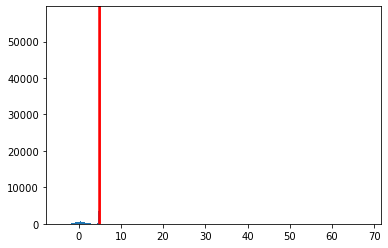

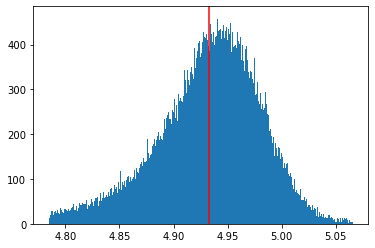

In [6]:
Sazi_mf, cellID_mf, pump_mf = filter_mean(Sazi, q, [0.1, 0.3], cellID, pump, sigma=2)

In [7]:
#Sazi_mf2, cellID_mf2, pump_mf2 = filter_mean(Sazi_mf, q, [0.1, 0.3], cellID_mf, pump_mf, sigma=2)

# CALCULATE DIFFERENCE

In [8]:
def calc_diff(Sazi_in, q, cellID_in, pump_in):
    
    print(Sazi_in.shape, cellID_in.shape, pump_in.shape)
    
    
    cells = np.unique(cellID_in)
    print(cells.shape)
    S_on = np.zeros([len(cells), len(q)])
    S_off = np.zeros([len(cells), len(q)])
    for i in range(cells.shape[0]):
        S_on[i,:] = np.nanmean(Sazi_in[np.logical_and(pump_in==1, cellID_in==cells[i]),:],0)    
        S_off[i,:] = np.nanmean(Sazi_in[np.logical_and(pump_in==0, cellID_in==cells[i]),:],0)
    dS = S_on - S_off
    return dS, S_on, S_off

In [9]:
dS, S_on, S_off = calc_diff(Sazi_mf, q, cellID_mf, pump_mf)

(84169, 256) (84169,) (84169,)
(184,)


# PLOT DIFFERENCE

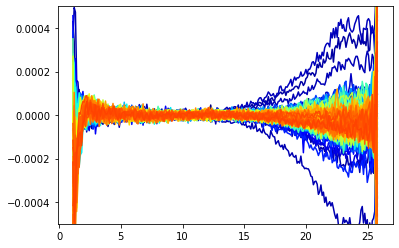

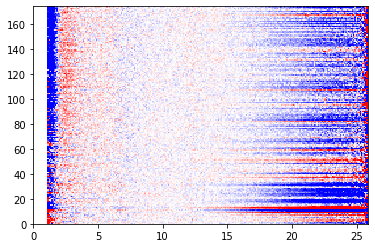

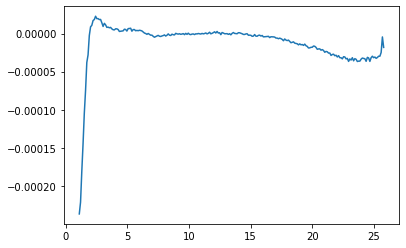

In [10]:

cells = np.unique(cellID)
colors = pl.cm.jet(np.linspace(0,1,dS.shape[0]))
#dS_filt = dS[mask_std,:]

fig, ax = plt.subplots(1,1)
for i in range(dS.shape[0]-30):
    ax.plot(q, dS[i+3,:].T, color = colors[i])
    ax.set_ylim([-.0005,.0005])
    

cmin = -0.0001
cmax = 0.0001
    
fig, ax = plt.subplots(1,1)
ax.pcolor(q, cells[:175], dS[:175,:], cmap='bwr',vmin=cmin, vmax=cmax)

fig, ax = plt.subplots(1,1)
ax.plot(q, np.nanmean(dS,0))

